# Timing distance calculations

I want to create 3-4 simple models in order to show the effect of the distance algorithm for Kriging and how it can be applied to Gempy models. In general I think 3 Layers should be fine, cutting out the central one. Keeping all in the same size around max 5000 grid points gives reasonable calculation times.
1) flat horizontal 
2) anticline 
3) recumbent anticline
4) layer pinching out ?
5) should be something like a fault

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Importing auxiliary libraries
import numpy as np
import matplotlib 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import pandas as pd

import gempy.utils.Kriging_Jan as krige
import psutil

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
d = {'X': [500, 500], 'Y': [10, 10], 'Z': [500,500], 'Property': [20, 20]}
data_field = pd.DataFrame(data=d)

In [3]:
x = np.arange(2,9,1)
print(x)

[2 3 4 5 6 7 8]


In [4]:
number_gridpoints = np.zeros(len(x))
maxmem = np.zeros(len(x))
step1 = np.zeros(len(x))
step2 = np.zeros(len(x))
step3 = np.zeros(len(x))
step4 = np.zeros(len(x))
dist_total = np.zeros(len(x))
matrix_extr = np.zeros(len(x))
krig_calc = np.zeros(len(x))

In [5]:
print(maxmem)
maxmem[:][2]=1
print(maxmem)

[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0.]


In [13]:
for i in range(len(x)):
    geo_data = gp.create_data([0,1000,0,20,0,1000],resolution=[100,x[i],100], 
                            path_o = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_orientations_slice.csv", path_i = "C:/Users/Jan/gempy/notebooks/prototype_notebooks/JanThesis/Jan_thesis_model1_interfaces_slice.csv")
    gp.set_series(geo_data, {"Strat_Series": ('rock2','rock1'),"Basement_Series":('basement')},order_series = ['Strat_Series','Basement_Series'],
                       order_formations=np.array(['rock2','rock1','basement']), verbose=0)
    interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True, theano_optimizer='fast_compile')
    lith_block, fault_block = gp.compute_model(interp_data)
    process = psutil.Process(os.getpid())
    test = krige.Kriging(data_field, lith_block, geo_data, formation_number=2, kriging_type='OK', distance_type='deformed_B', an_factor=1, var_par=(200,50,1))
    number_gridpoints[:][i] = len(test.grid_dataframe)
    maxmem[:][i] = process.memory_info().rss/1000/1000
    step1[:][i] = test.tstep1
    step2[:][i] = test.tstep2
    step3[:][i] = test.tstep3
    step4[:][i] = test.tstep4
    dist_total[:][i] = test.tstep1+test.tstep2+test.tstep3+test.tstep4
    matrix_extr[:][i] = test.time_sub+test.time_dist
    krig_calc[:][i] = test.time_krig

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


initializing: 0.06696343421936035
distance precalculation: 1.0116002559661865
submatrix extraction: 0.004995584487915039
distance Matrices: 0.32389187812805176
kriging calculation: 0.5276157855987549
Negative Variances: 0
Out of: 4001
Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0
initializing: 0.0029993057250976562
distance precalculation: 1.2729175090789795
submatrix extraction: 0.013001441955566406
distance Matrices: 0.4926891326904297
kriging calculation: 0.7781517505645752
Negative Variances: 0
Out of: 6001
Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0
initializing: 0.007994651794433594
distance precalculation: 2.1682801246643066
submatrix extraction: 0.011997699737548828
distance Matrices: 0.7473094463348389
kriging calculation: 1.0126745700836182
Negative Variances: 0
Out of: 8001
Compiling theano f

In [14]:
# create the dataframe and populate with data
da = {'#gridpoints': number_gridpoints, 'maxmem': maxmem, 'step1': step1, 'step2': step2,
      'step3': step3,'step4': step4,'total': dist_total, 'matrix_extr': matrix_extr, 'krig_calc': krig_calc}
df_time_mem = pd.DataFrame(data=da)


In [15]:
print(df_time_mem)

   #gridpoints       maxmem     step1     step2     step3     step4     total  \
0       4000.0   476.667904  0.024046  0.075005  0.390837  0.521713  1.011600   
1       6000.0   645.001216  0.003995  0.133119  0.328000  0.806811  1.271925   
2       8000.0   873.783296  0.003993  0.170915  0.668134  1.324238  2.167280   
3      10000.0  1167.732736  0.002997  0.268844  1.038400  1.725006  3.035247   
4      12000.0  1530.408960  0.003997  0.290255  1.285691  2.682843  4.262785   
5      14000.0  1938.624512  0.006995  0.448741  2.127772  3.667768  6.251276   
6      16000.0  2419.253248  0.004996  0.413993  2.405707  4.593918  7.418614   

   matrix_extr  krig_calc  
0     0.328887   0.527616  
1     0.505691   0.778152  
2     0.759307   1.012675  
3     1.071438   1.367365  
4     1.610792   1.722338  
5     1.827502   1.878002  
6     2.387311   2.178512  


In [16]:
df_time_mem['matrix_extr'].values

array([0.32888746, 0.50569057, 0.75930715, 1.07143784, 1.61079192,
       1.82750154, 2.38731098])

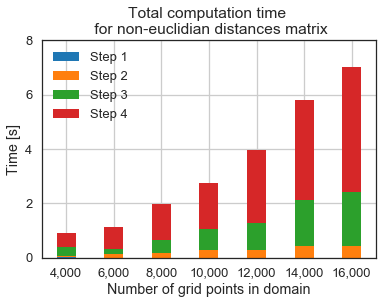

In [23]:
N = len(x)
ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, step1, width)
p2 = plt.bar(ind, step2, width,
             bottom=step1)
p3 = plt.bar(ind, step3, width,
             bottom=step2)
p4 = plt.bar(ind, step4, width,
             bottom=step3)

plt.grid()
plt.ylabel('Time [s]')
plt.xlabel('Number of grid points in domain')
plt.title('Total computation time \n for non-euclidian distances matrix')
plt.xticks(ind, ('4,000', '6,000', '8,000', '10,000', '12,000', '14,000', '16,000'))
plt.yticks(np.arange(0, 10, 2))
plt.legend((p1[0], p2[0], p3[0], p4[0]), ('Step 1', 'Step 2', 'Step 3', 'Step 4'))
plt.savefig(fname='Plot_time_dist', edgecolor='black', bbox_inches='tight')
plt.show()

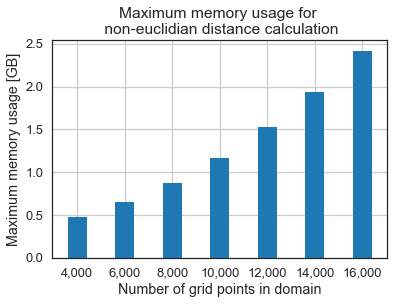

In [22]:
N = len(x)
ind = np.arange(N)    # the x locations for the groups
width = 0.4      # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, maxmem/1000, width)

plt.grid()
plt.ylabel('Maximum memory usage [GB]')
plt.xlabel('Number of grid points in domain')
plt.title('Maximum memory usage for \n non-euclidian distance calculation', loc='center')
plt.xticks(ind, ('4,000', '6,000', '8,000', '10,000', '12,000', '14,000', '16,000'))
plt.yticks(np.arange(0, 3, .5))

plt.savefig(fname='Plot_memory', edgecolor='black', bbox_inches='tight')
plt.show()

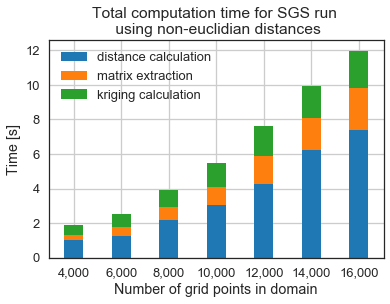

In [21]:
N = len(x)
ind = np.arange(N)    # the x locations for the groups
width = 0.4       # the width of the bars: can also be len(x) sequence

p11 = plt.bar(ind, dist_total, width)

p22 = plt.bar(ind, matrix_extr, width,
             bottom=dist_total)

p33 = plt.bar(ind, krig_calc, width,
            bottom=matrix_extr+dist_total)

plt.grid()
plt.ylabel('Time [s]')
plt.xlabel('Number of grid points in domain')
plt.title('Total computation time for SGS run \n using non-euclidian distances')
plt.xticks(ind, ('4,000', '6,000', '8,000', '10,000', '12,000', '14,000', '16,000'))
plt.yticks(np.arange(0, 14, 2))
plt.legend((p11[0], p22[0], p33[0]), ('distance calculation', 'matrix extraction', 'kriging calculation'))
plt.savefig(fname='Plot_time_SGS', edgecolor='black', bbox_inches='tight')
plt.show()
